In [1]:


%matplotlib inline
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import *
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from qiskit_finance.applications.optimization import PortfolioDiversification
register_matplotlib_converters()
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver,QAOA,SamplingVQE
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit_aer.primitives import Sampler
stocks = ["SPY","AVGO","META","ASML","GOOG","AMZN","IONQ","XOM","AAPL","MSFT","IBM",]


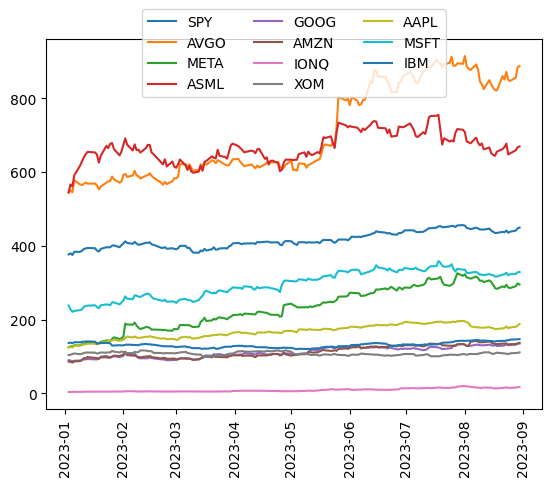

In [2]:


try:
    data = YahooDataProvider(
        tickers=stocks,
        start=datetime.datetime(2023, 1, 1),
        end=datetime.datetime(2023, 8, 31),
    )

    data.run()

    for (cnt, s) in enumerate(data._tickers):
        plt.plot(data._data[cnt], label=s)
 
        
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)
    plt.xticks(rotation=90)
    plt.show()
except QiskitFinanceError as ex:
    data = None
    print(ex)



Means:
[415.88302778 705.04579512 232.05771085 665.96624793 111.52713872
 112.44078349   8.72108437 107.52580983 166.97643441 295.4595632
 131.12314495]
A time-series similarity measure:
[[1.00000000e+00 2.08328909e-05 3.27707657e-05 2.40883670e-05
  1.97929352e-05 1.98525304e-05 1.47953326e-05 1.95360966e-05
  2.42022371e-05 5.00242740e-05 2.11550037e-05]
 [2.08328909e-05 1.00000000e+00 1.27362540e-05 8.55765061e-05
  1.01498012e-05 1.01654496e-05 8.65127475e-06 1.00818325e-05
  1.11957618e-05 1.47077609e-05 1.04963559e-05]
 [3.27707657e-05 1.27362540e-05 1.00000000e+00 1.38833322e-05
  5.15492747e-05 5.63133151e-05 2.69731682e-05 4.83739213e-05
  1.16898179e-04 2.13715286e-04 6.58992583e-05]
 [2.40883670e-05 8.55765061e-05 1.38833322e-05 1.00000000e+00
  1.08652083e-05 1.08831423e-05 9.16567625e-06 1.07873570e-05
  1.20725839e-05 1.62590761e-05 1.12632964e-05]
 [1.97929352e-05 1.01498012e-05 5.15492747e-05 1.08652083e-05
  1.00000000e+00 2.84944972e-03 5.85967084e-05 5.63697128e-04
 

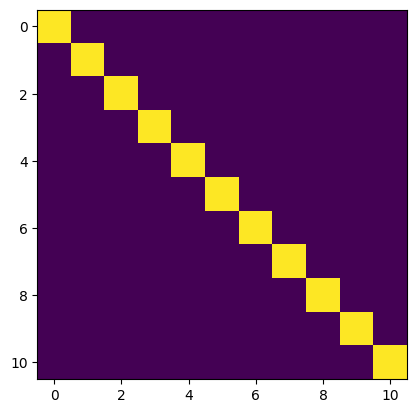

A covariance matrix:
[[ 4.72948833e+02  2.58844301e+03  1.15532020e+03  6.38474276e+02
   2.74550574e+02  3.33616178e+02  9.12028674e+01 -2.33706098e+01
   3.61964129e+02  7.17874971e+02  8.79400266e+01]
 [ 2.58844301e+03  1.58962617e+04  6.70521947e+03  3.68365013e+03
   1.58218411e+03  1.92116473e+03  5.28123873e+02 -2.36892773e+02
   2.06250260e+03  4.16420638e+03  5.05934877e+02]
 [ 1.15532020e+03  6.70521947e+03  3.27004311e+03  1.55676554e+03
   7.53200089e+02  8.63867678e+02  2.32172015e+02 -9.69052908e+01
   1.01679443e+03  2.05076481e+03  1.38468732e+02]
 [ 6.38474276e+02  3.68365013e+03  1.55676554e+03  1.62232006e+03
   3.98942744e+02  4.69783205e+02  1.12238129e+02 -5.94530332e+01
   5.42740256e+02  1.11816847e+03  8.22591770e+01]
 [ 2.74550574e+02  1.58218411e+03  7.53200089e+02  3.98942744e+02
   1.99213243e+02  2.15665849e+02  5.61642441e+01 -2.14254710e+01
   2.30786398e+02  4.81309288e+02  4.44291326e+01]
 [ 3.33616178e+02  1.92116473e+03  8.63867678e+02  4.69783205e+0

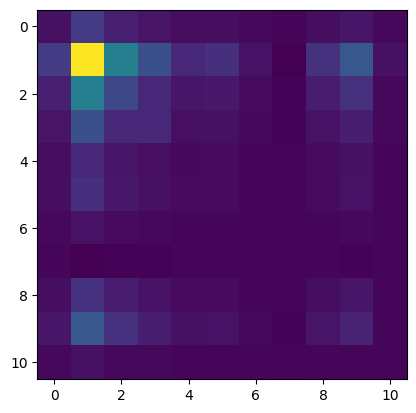

In [3]:



means = data.get_mean_vector()
print("Means:")
print(means)

rho = data.get_similarity_matrix()
print("A time-series similarity measure:")
print(rho)
plt.imshow(rho)
plt.show()

cov = data.get_covariance_matrix()
print("A covariance matrix:")
print(cov)
plt.imshow(cov)
plt.show()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()


In [4]:
from qiskit.utils import algorithm_globals


class QuantumOptimizer:
    def __init__(self, rho, n, q):
        self.rho = rho
        self.n = n
        self.q = q
        self.pdf = PortfolioDiversification(similarity_matrix=rho, num_assets=n, num_clusters=q)
        self.qp = self.pdf.to_quadratic_program()
        
    # Obtains the least eigenvalue of the Hamiltonian classically
    def exact_solution(self):
        exact_mes = NumPyMinimumEigensolver()
        exact_eigensolver = MinimumEigenOptimizer(exact_mes)
        result = exact_eigensolver.solve(self.qp)
        print (result)
        return self.decode_result(result)

    def vqe_solution(self):
        algorithm_globals.random_seed = 100
        cobyla = COBYLA()
        cobyla.set_options(maxiter=250)
        ry = TwoLocal(n, "ry", "cz", reps=5, entanglement="full")
        vqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
        vqe = MinimumEigenOptimizer(vqe_mes)
        result = vqe.solve(self.qp)
        return self.decode_result(result)

    def qaoa_solution(self):
        algorithm_globals.random_seed = 1234
        cobyla = COBYLA()
        cobyla.set_options(maxiter=250)
        qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
        qaoa = MinimumEigenOptimizer(qaoa_mes)
        result = qaoa.solve(self.qp)
        return self.decode_result(result)

    def decode_result(self, result, offset=0):
        quantum_solution = 1 - (result.x)
        ground_level = self.qp.objective.evaluate(result.x)
        return quantum_solution, ground_level
    def mkr_to_ising(self):
        return self.qp.to_ising()
        

In [5]:
#Problem def
#select a portfolio q of assets that represent the market = SPY 
#with n assets, where q is significantly smaller than n,
#To determine how to group assets into clusters 
#and how to determine which assets should represent the clusters amounts to solving the problem

q = 1  # q less or equal than n
n = 4  # number of assets

# Instantiate the quantum optimizer class with parameters:
quantum_optimizer = QuantumOptimizer(rho, n, q)


In [6]:


# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    tickers=stocks
    plt.figure()
    plt.scatter(xc, yc, s=200)
    
  
    for i in range(len(xc)):
        #plt.annotate(i, (xc[i] + 0.400, yc[i]), size=16, color="r")
        plt.annotate([tickers[i]], (xc[i] + 0.015, yc[i]), size=16, color="r")
        
    plt.grid()

    for ii in range(n**2, n**2 + n):


        if x[ii] > 0:
            plt.plot(xc[ii - n**2], yc[ii - n**2], "r*", ms=20)

    for ii in range(0, n**2):

        if x[ii] > 0:
            iy = ii // n
            ix = ii % n
            plt.plot([xc[ix], xc[iy]], [yc[ix], yc[iy]], "C2")

    plt.title(title_str + " cost = " + str(int(C * 100) / 100.0))
    plt.show()



In [7]:
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.problems import QuadraticProgram

ground_state, ground_level = quantum_optimizer.exact_solution()
print(ground_state)

problem = quantum_optimizer.qp
#print(problem.prettyprint())
conv = QuadraticProgramToQubo()
problem2 = conv.convert(problem)


qubitOp, offset = problem2.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
#print(str(qubitOp))

# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
ground_state = exact.solve(problem2)
quantum_solution = 1 - (ground_state.x)
cost_solution = problem2.objective.evaluate(ground_state.x)

print ("Ground State")
print(ground_state)
print ("Cost")
print(cost_solution)



#Hamiltonian = total energy of the system kinetic + potential energy H = k + V
#How to find the Hamiltonian of a system?
#The Hamiltonian of a system is the sum of the kinetic and potential energies of that system.
#In qiskit the Hamiltonian is calculated by the function to_ising() which returns the Hamiltonian and the offset.

#The offset is the sum of the constant terms in the Hamiltonian.
#The Hamiltonian is a sum of Pauli terms, each of which is a tensor product of Pauli operators.
#The ground state of the Hamiltonian is the state with the lowest energy. And is the solution to the problem.
#for example, the Hamiltonian of a system of two qubits is:
#H = 0.5 * ZI + 0.5 * IZ - 0.5 * ZZ
#The ground state of this Hamiltonian is the state |01> or |10> with energy -0.5.
#The Hamiltonian of a system of three qubits is:
#H = 0.5 * ZII + 0.5 * IZI + 0.5 * IIZ - 0.5 * ZZI - 0.5 * IZZ - 0.5 * ZIZ + 0.5 * ZZZ
#The ground state of this Hamiltonian is the state |001> or |010> or |100> with energy -1.5.
#The Hamiltonian of a system of four qubits is:
#H = 0.5 * ZIII + 0.5 * IZII + 0.5 * IIIZ + 0.5 * IIZI - 0.5 * ZIIZ - 0.5 * IZIZ - 0.5 * IIZZ - 0.5 * ZZII - 0.5 * IZZI - 0.5 * ZIZI - 0.5 * ZZZI - 0.5 * IZZZ - 0.5 * ZIZZ + 0.5 * ZZIZ + 0.5 * ZZZZ
#The ground state of this Hamiltonian is the state |0001> or |0010> or |0100> or |1000> with energy -2.5.
#The Shrodinger equation is the equation that describes the evolution of a quantum system.
#The Shrodinger equation  in qiskit is solved by the function solve() which returns the ground state of the Hamiltonian.
# With the ground state of the Hamiltonian we can plot the solution of the problem.
# The solution cost of the classical is obtained by the function evaluate() which returns the cost of the solution.
# The cost of the solution is the sum of the constant terms in the Hamiltonian plus the sum of the terms in the Hamiltonian that are equal to one.
# subtract the offset from the cost to obtain the solution cost of the problem. In qiskit the offset is obtained by the function offset. 
#classical_cost = 1.000779571614484 # obtained from the CPLEX solution

#try:
#    if np.abs(ground_level - (classical_cost)) < 0.01:
#        print("Ising Hamiltonian in Z basis is correct")
#    else:
#        print("Error in the Ising Hamiltonian formulation")
#except Exception as ex:
#print(ex)
#quantum_optimizer.pdf.interpret(ground_state)

fval=1.0001235482053474, x_0_0=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=1.0, x_1_0=0.0, x_1_1=0.0, x_1_2=0.0, x_1_3=1.0, x_2_0=0.0, x_2_1=0.0, x_2_2=0.0, x_2_3=1.0, x_3_0=0.0, x_3_1=0.0, x_3_2=0.0, x_3_3=1.0, y_0=0.0, y_1=0.0, y_2=0.0, y_3=1.0, status=SUCCESS
[1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0.]
Offset: 1902.142605975066
Ising Hamiltonian:
Ground State
fval=-1.0001235482050106, x_0_0=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=1.0, x_1_0=0.0, x_1_1=0.0, x_1_2=0.0, x_1_3=1.0, x_2_0=0.0, x_2_1=0.0, x_2_2=0.0, x_2_3=1.0, x_3_0=0.0, x_3_1=0.0, x_3_2=0.0, x_3_3=1.0, y_0=0.0, y_1=0.0, y_2=0.0, y_3=1.0, status=SUCCESS
Cost
-1.0001235482050106


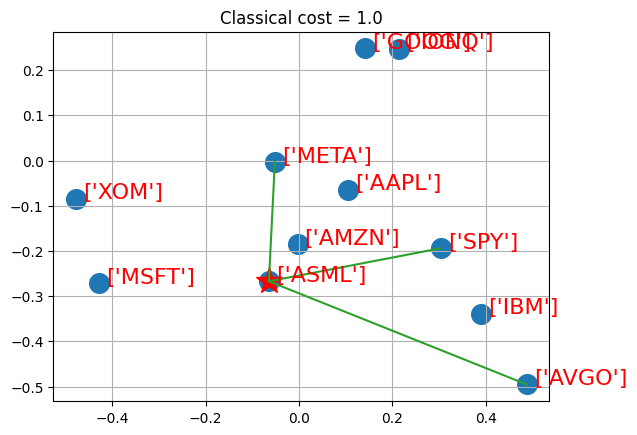

In [8]:
xc, yc = data.get_coordinates()


visualize_solution(xc, yc, ground_state, ground_level, n, q, "Classical")
#selected stocks via the stars and in green the links (via similarities) 
# with other stocks that are represented in the fund by the linked stock. 

In [9]:
#visualize_solution(xc, yc, vqe_state, vqe_level, n, q, "VQE")

In [10]:
#visualize_solution(xc, yc, qaoa_state, qaoa_level, n, q, "QAOA")